In [1]:
!python --version # better be 3.10

!pip install torch==2.1.0 # ignore torchaudio and torchvision

!apt-get update
!apt-get install build-essential
!pip install ninja
!pip install "causal-conv1d>=1.2.0"

!pip install mamba-ssm

!pip install datasets evaluate accelerate
!pip install tslearn

Python 3.10.12
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler, TimeSeriesScalerMinMax

from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from mamba_ssm import Mamba2

import causal_conv1d
from causal_conv1d import causal_conv1d_fn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = 'drive/MyDrive/neuro2voc/task_4/data/'

In [ ]:
load_tensor_data_dir = data_dir+'2_concatenated/data_'
# load_tensor_labels_dir = data_dir+'2_concatenated/labels_'
# load_tensor_data_dir = data_dir+'1_tensors/data_' # some tensors mistakenly saved to this folder, but shouldnt be there any more, as I have manually moved them to 2_concatenated
load_tensor_labels_dir = data_dir+'1_tensors/labels_' # but it seems that I have to use this for generated tensor data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [ ]:
before = "2500"
after = "1250"
window_size = "500"
step_size = "1"

In [ ]:
tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}_{window_size}_{step_size}.pt")
tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}_{window_size}_{step_size}.pt")
tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}_{window_size}_{step_size}.pt")
data = torch.cat((tensor_1, tensor_2, tensor_3), dim=0)
assert len(data) == len(tensor_1) + len(tensor_2) + len(tensor_3)

labels_1 = torch.load(f"{load_tensor_labels_dir}1_{before}_{after}.pt")
labels_2 = torch.load(f"{load_tensor_labels_dir}2_{before}_{after}.pt")
labels_3 = torch.load(f"{load_tensor_labels_dir}3_{before}_{after}.pt")
labels = torch.cat((labels_1, labels_2, labels_3), dim=0)
assert len(labels) == len(labels_1) + len(labels_2) + len(labels_3)
assert len(labels_1) == len(tensor_1)
assert len(labels_2) == len(tensor_2)
assert len(labels_3) == len(tensor_3)

print(data.shape)
data = data.permute(0, 2, 1)
print(data.shape)
print(labels.shape)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

mask_train = y_train != 6
mask_test = y_test != 6

X_train_filtered = X_train[mask_train]
y_train_filtered = y_train[mask_train]
X_test_filtered = X_test[mask_test]
y_test_filtered = y_test[mask_test]

print(X_train_filtered.shape)
print(y_train_filtered.shape)
print(X_test_filtered.shape)
print(y_test_filtered.shape)

train_dataset = TensorDataset(X_train_filtered, y_train_filtered)
test_dataset = TensorDataset(X_test_filtered, y_test_filtered)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(train_loader)
print(test_loader)

<ipython-input-8-4e1143b4d0ec>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}_{window_size}_{step_size}.pt

torch.Size([3459, 75, 3250])
torch.Size([3459, 3250, 75])
torch.Size([3459])
torch.Size([2767, 3250, 75]) torch.Size([2767])
torch.Size([692, 3250, 75]) torch.Size([692])


<ipython-input-8-4e1143b4d0ec>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-8-4e1143b4d0ec>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


Shape of X_train: torch.Size([2767, 3250, 75])
Shape of y_train: torch.Size([2767])
Shape of X_test: torch.Size([692, 3250, 75])
Shape of y_test: torch.Size([692])
torch.Size([2765, 3250, 75])
torch.Size([2765])
torch.Size([689, 3250, 75])
torch.Size([689])


# Define models

In [ ]:
# class CNN_LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(CNN_LSTM, self).__init__()
#         self.cnn = nn.Sequential(
#             nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2),
#             nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2)
#         )
#         self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size, 100),
#             nn.ReLU(),
#             nn.Linear(100, num_classes)
#         )

#     def forward(self, x):
#         # CNN takes input of shape (batch_size, channels, seq_len)
#         x = x.permute(0, 2, 1)
#         out = self.cnn(x)
#         # Global max pooling
#         out, _ = torch.max(out, 2)
#         # LSTM takes input of shape (batch_size, seq_len, input_size)
#         out = out.unsqueeze(1).repeat(1, out.size(1), 1)
#         out, _ = self.lstm(out)
#         out = self.fc(out[:, -1, :])
#         return out

In [30]:
class ParallelCNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.1):
        super(ParallelCNNLSTMModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

In [32]:
class ParallelCNNLSTMModel2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.1):
        super(ParallelCNNLSTMModel2, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128, 128),  # Replace LazyLinear with regular Linear
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out


In [33]:
cnn_lstm_parallel2 = ParallelCNNLSTMModel2(input_size, hidden_size, num_layers, num_classes).to(device)
print(f"Total parameters: {sum(p.numel() for p in cnn_lstm_parallel2.parameters()):,}")

Total parameters: 310,790


In [22]:
class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BasicLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        out = self.fc(out[:, -1, :])
        return out

In [ ]:
print(f"Total parameters: {sum(p.numel() for p in basic_lstm.parameters()):,}")

In [19]:
class MambaModel(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand, num_classes):
        super(MambaModel, self).__init__()

        # Store dimensions
        self.input_dim = input_dim
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.num_classes = num_classes

        # Fixed head dimension
        headdim = 8

        # Calculate d_ssm
        d_ssm = self.d_state * self.expand

        # Ensure d_ssm is divisible by headdim
        assert d_ssm % headdim == 0, f"d_ssm ({d_ssm}) is not divisible by headdim ({headdim})"

        # Input projection to match d_model
        self.input_proj = nn.Linear(self.input_dim, self.d_model)

        # Initialize Mamba2 with the correct d_model
        self.mamba = Mamba2(
            d_model=self.d_model,
            d_state=self.d_state,
            d_conv=self.d_conv,
            expand=self.expand,
            headdim=headdim,
            ngroups=1,
            rmsnorm=True,
            norm_before_gate=False,
            dt_min=0.001,
            dt_max=0.1,
            dt_init_floor=1e-4,
            dt_limit=(0.0, float("inf")),
            bias=False,
            conv_bias=True,
            chunk_size=256,
            use_mem_eff_path=True,
            layer_idx=None,
            process_group=None,
            sequence_parallel=True,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            dtype=None
        )

        # Output linear layer
        self.fc = nn.Linear(self.d_model, self.num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        print("Input shape to MambaModel:", x.shape)

        # Project input to d_model dimensions
        x = self.input_proj(x)  # Shape: (batch_size, seq_len, d_model)
        print("Shape after input projection:", x.shape)

        # Permute to match Mamba2's expected input shape
        x = x.permute(0, 2, 1)  # Shape: (batch_size, d_model, seq_len)
        print("Shape after permute:", x.shape)

        # Pass through Mamba2
        out = self.mamba(x)
        print("Output shape from Mamba2:", out.shape)

        # Permute back to (batch_size, seq_len, d_model)
        out = out.permute(0, 2, 1)
        print("Shape after permuting back:", out.shape)

        # Use the output of the last time step
        out = self.fc(out[:, -1, :])
        print("Output shape after Linear layer:", out.shape)
        return out


In [21]:
# Parameters
input_dim = 75      # Input feature dimension
d_model = 32       # Model dimension (should be divisible by headdim)
d_state = 16       # State dimension
d_conv = 4         # Convolution dimension
expand = 2         # Expansion factor
num_classes = 6    # Number of output classes

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = MambaModel(
    input_dim=input_dim,
    d_model=d_model,
    d_state=d_state,
    d_conv=d_conv,
    expand=expand,
    num_classes=num_classes
).to(device)

# Print total parameters
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Total parameters: 10,622


In [38]:
class MambaModel2(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand, num_classes):
        super(MambaModel2, self).__init__()

        # Store dimensions
        self.input_dim = input_dim
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.num_classes = num_classes

        # Fixed head dimension
        headdim = 8

        # Calculate d_ssm
        d_ssm = self.d_state * self.expand

        # Ensure d_ssm is divisible by headdim
        assert d_ssm % headdim == 0, f"d_ssm ({d_ssm}) is not divisible by headdim ({headdim})"

        # Input projection to match d_model
        self.input_proj = nn.Linear(self.input_dim, self.d_model)

        # First Mamba2 layer
        self.mamba1 = Mamba2(
            d_model=self.d_model,
            d_state=self.d_state,
            d_conv=self.d_conv,
            expand=self.expand,
            headdim=headdim,
            ngroups=1,
            rmsnorm=True,
            norm_before_gate=False,
            dt_min=0.001,
            dt_max=0.1,
            dt_init_floor=1e-4,
            dt_limit=(0.0, float("inf")),
            bias=False,
            conv_bias=True,
            chunk_size=256,
            use_mem_eff_path=True,
            layer_idx=None,
            process_group=None,
            sequence_parallel=True,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            dtype=None
        )

        # Second Mamba2 layer
        self.mamba2 = Mamba2(
            d_model=self.d_model,
            d_state=self.d_state,
            d_conv=self.d_conv,
            expand=self.expand,
            headdim=headdim,
            ngroups=1,
            rmsnorm=True,
            norm_before_gate=False,
            dt_min=0.001,
            dt_max=0.1,
            dt_init_floor=1e-4,
            dt_limit=(0.0, float("inf")),
            bias=False,
            conv_bias=True,
            chunk_size=256,
            use_mem_eff_path=True,
            layer_idx=None,
            process_group=None,
            sequence_parallel=True,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            dtype=None
        )

        # Output linear layer
        self.fc = nn.Linear(self.d_model, self.num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        print("Input shape to MambaModel:", x.shape)

        # Project input to d_model dimensions
        x = self.input_proj(x)  # Shape: (batch_size, seq_len, d_model)
        print("Shape after input projection:", x.shape)

        # Permute to match Mamba2's expected input shape
        x = x.permute(0, 2, 1)  # Shape: (batch_size, d_model, seq_len)
        print("Shape after permute:", x.shape)

        # Pass through first Mamba2 layer
        x = self.mamba1(x)
        print("Output shape from first Mamba2 layer:", x.shape)

        # Optionally, apply activation function or normalization here
        # x = F.relu(x)

        # Pass through second Mamba2 layer
        x = self.mamba2(x)
        print("Output shape from second Mamba2 layer:", x.shape)

        # Permute back to (batch_size, seq_len, d_model)
        x = x.permute(0, 2, 1)
        print("Shape after permuting back:", x.shape)

        # Use the output of the last time step
        out = self.fc(x[:, -1, :])
        print("Output shape after Linear layer:", out.shape)
        return out

In [39]:
# Parameters
input_dim = 75      # Input feature dimension
d_model = 32       # Model dimension (should be divisible by headdim)
d_state = 16       # State dimension
d_conv = 4         # Convolution dimension
expand = 2         # Expansion factor
num_classes = 6    # Number of output classes

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = MambaModel2(
    input_dim=input_dim,
    d_model=d_model,
    d_state=d_state,
    d_conv=d_conv,
    expand=expand,
    num_classes=num_classes
).to(device)

# Print total parameters
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Total parameters: 18,614


In [ ]:
class SmallMamba(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand, num_classes, seq_len):
        super(SmallMamba, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.output_proj = nn.Linear(d_model, num_classes)
        self.seq_len = seq_len

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, input_dim = x.shape

        # Project input to d_model dimension
        x = self.input_proj(x)  # Shape: (batch_size, seq_len, d_model)

        # Process in chunks if sequence is too long
        chunk_size = 1024  # Adjust this value based on your GPU memory
        outputs = []

        for i in range(0, seq_len, chunk_size):
            chunk = x[:, i:i+chunk_size, :]
            chunk = chunk.transpose(1, 2)  # (batch_size, d_model, chunk_size)
            chunk_output = self.mamba(chunk)
            chunk_output = chunk_output.transpose(1, 2)  # (batch_size, chunk_size, d_model)
            outputs.append(chunk_output)

        x = torch.cat(outputs, dim=1)  # (batch_size, seq_len, d_model)

        # Global average pooling
        x = x.mean(dim=1)  # Shape: (batch_size, d_model)

        # Project to number of classes
        x = self.output_proj(x)  # Shape: (batch_size, num_classes)

        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Initialize Models

In [ ]:
print(X_train_filtered.shape[-1])
print(len(np.unique(y_train_filtered)))
np.unique(y_train_filtered)

75
6


array([0, 1, 2, 3, 4, 5])

In [23]:
input_size = 75
hidden_size = 128
num_layers = 2
num_classes = 6

In [24]:
input_dim = 75
d_model = 128
d_state = 16
d_conv = 4
expand = 2
num_classes = 6
seq_len = 3250

In [25]:
# cnn_lstm = CNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
basic_lstm = BasicLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
# cnn_lstm_parallel = ParallelCNNLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
# small_mamba = SmallMamba(input_dim, d_model, d_state, d_conv, expand, num_classes, seq_len).to(device)

In [ ]:
# input_dim = 75  # number of input channels (neurons)
# d_model = 1400  # sequence length
# d_state = 64
# d_conv = 4
# expand = 2
# d_ssm = d_state * expand
# headdim = 32  # Ensure d_ssm is divisible by headdim
# num_classes = len(np.unique(y_train_filtered))  # Number of classes

# # Debugging assertion to ensure d_ssm is divisible by headdim
# assert d_ssm % headdim == 0, f"d_ssm ({d_ssm}) is not divisible by headdim ({headdim})"

In [ ]:
# mamba2 = Mamba2(
#     d_model=75,
#     d_state=64,
#     d_conv=4,
#     expand=2,
#     headdim=32,
#     d_ssm=128
# ).to(device)

In [ ]:
# mamba2

In [ ]:
# mamba = MambaModel(input_dim, d_model, d_state, d_conv, expand, headdim, num_classes).to(device)

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(cnn_lstm.parameters(), lr=0.001)

In [ ]:
# def train(models: List[nn.Module], train_loader: DataLoader, epochs: int):
#     criterion = nn.CrossEntropyLoss()

#     for model in models:
#         print("Training model: ", model.__class__.__name__)
#         model.train()
#         optimizer = Adam(model.parameters(), lr=0.001)

#         for epoch in range(epochs):
#             for i, (x, y) in enumerate(train_loader):
#                 x = x.to(device).float()  # Convert input to float
#                 y = y.to(device)
#                 optimizer.zero_grad()
#                 y_pred = model(x)
#                 loss = criterion(y_pred, y)
#                 loss.backward()
#                 optimizer.step()

#                 if (i+1) % 10 == 0:
#                     print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

#         print("Training completed for model: ", model.__class__.__name__)

In [ ]:
# models = [basic_lstm]
# num_epochs = 150
# train(models, train_loader, epochs=num_epochs)

In [ ]:
# def test(models, test_loader):
#     accuracy_dict = {}
#     with torch.no_grad():
#         for model in models:
#             model.eval()
#             correct = 0
#             total = 0
#             for x, y in test_loader:
#                 x = x.to(device)
#                 y = y.to(device)
#                 y_pred = model(x)
#                 _, predicted = torch.max(y_pred.data, 1)
#                 total += y.size(0)
#                 correct += (predicted == y).sum().item()
#             accuracy = 100 * correct / total
#             print(f'Accuracy of the {model.__class__.__name__} model on the test set: {accuracy:.2f} %')
#             accuracy_dict[model.__class__.__name__] = accuracy
#     return accuracy_dict

In [ ]:
# models = [cnn_lstm]
# accuracy_dict = test(models, test_loader)

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total_test += y.size(0)
                correct_test += (predicted == y).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    return train_accuracies, test_accuracies

In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 15
train_accuracies, test_accuracies = train_and_evaluate(small_mamba, train_loader, test_loader, num_epochs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x128 and 1024x8192)

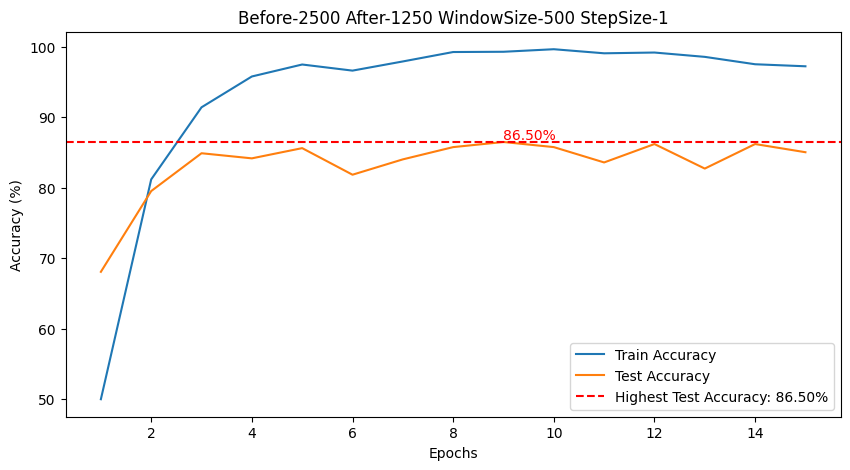

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')

max_test_accuracy = max(test_accuracies)
max_test_epoch = test_accuracies.index(max_test_accuracy) + 1

plt.axhline(y=max_test_accuracy, color='r', linestyle='--', label=f'Highest Test Accuracy: {max_test_accuracy:.2f}%')
plt.text(max_test_epoch, max_test_accuracy, f'{max_test_accuracy:.2f}%', color='red', va='bottom')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'Before-{before} After-{after} WindowSize-{window_size} StepSize-{step_size}')
plt.legend()

file_name = f"3_plots/result_parallelCNNLSTM_{before}_{after}_{window_size}_{step_size}.png"
file_path = data_dir+file_name
plt.savefig(file_path)

plt.show()

# Training

In [ ]:
# before = "750"
# after = "750"
# window_size = "500"
# step_size = "1"

In [ ]:
# tensor_1 = torch.load(f"{load_tensor_data_dir}1_{before}_{after}_{window_size}_{step_size}.pt")
# tensor_2 = torch.load(f"{load_tensor_data_dir}2_{before}_{after}_{window_size}_{step_size}.pt")
# tensor_3 = torch.load(f"{load_tensor_data_dir}3_{before}_{after}_{window_size}_{step_size}.pt")
# data = torch.cat((tensor_1, tensor_2, tensor_3), dim=0)
# assert len(data) == len(tensor_1) + len(tensor_2) + len(tensor_3)

# labels_1 = torch.load(f"{load_tensor_labels_dir}1_{before}_{after}.pt")
# labels_2 = torch.load(f"{load_tensor_labels_dir}2_{before}_{after}.pt")
# labels_3 = torch.load(f"{load_tensor_labels_dir}3_{before}_{after}.pt")
# labels = torch.cat((labels_1, labels_2, labels_3), dim=0)
# assert len(labels) == len(labels_1) + len(labels_2) + len(labels_3)
# assert len(labels_1) == len(tensor_1)
# assert len(labels_2) == len(tensor_2)
# assert len(labels_3) == len(tensor_3)

# print(data.shape)
# data = data.permute(0, 2, 1)
# print(data.shape)
# print(labels.shape)

# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.long)
# y_test = torch.tensor(y_test, dtype=torch.long)

# print("Shape of X_train:", X_train.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of X_test:", X_test.shape)
# print("Shape of y_test:", y_test.shape)

# mask_train = y_train != 6
# mask_test = y_test != 6

# X_train_filtered = X_train[mask_train]
# y_train_filtered = y_train[mask_train]
# X_test_filtered = X_test[mask_test]
# y_test_filtered = y_test[mask_test]

# print(X_train_filtered.shape)
# print(y_train_filtered.shape)
# print(X_test_filtered.shape)
# print(y_test_filtered.shape)

# train_dataset = TensorDataset(X_train_filtered, y_train_filtered)
# test_dataset = TensorDataset(X_test_filtered, y_test_filtered)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# input_size = 75
# hidden_size = 128
# num_layers = 2
# num_classes = 6

# cnn_lstm_parallel = ParallelCNNLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
# criterion = nn.CrossEntropyLoss()
# num_epochs = 15
# train_accuracies, test_accuracies = train_and_evaluate(cnn_lstm_parallel, train_loader, test_loader, num_epochs)

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
# plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy (%)')
# plt.title(f'before:{before}, after:{after}, window:{window_size}, step:{step_size}')
# plt.legend()
# filename = f'accuracy_plot_before_{before}_after_{after}_window_{window_size}_step_{step_size}.png'
# plt.savefig(filename)

# # Show the plot
# plt.show()

# # Confirming the save
# print(f"Plot saved as {filename}")
# plt.show()